In [1]:
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from scipy.stats import norm, t
from scipy.optimize import minimize
from sklearn.decomposition import PCA

# Problem 1

In [2]:
df_problem_1 = pd.read_csv('problem1.csv')
df_problem_1.head(3)

,X
0,-0.118037
1,0.149343
2,-0.083849


### 1A.

In [3]:
array_problem_1 = np.array(df_problem_1['X'])
pb1_mean = np.mean(array_problem_1)
pb1_var = np.var(array_problem_1)
pb1_skewness = stats.skew(array_problem_1)
pb1_kurtosis = stats.kurtosis(array_problem_1) 
print("A:")
print(f"    Mean: {pb1_mean:.4f}")
print(f"    Variance: {pb1_var:.4f}")
print(f"    Skewness: {pb1_skewness:.4f}")
print(f"    Kurtosis: {pb1_kurtosis:.4f}")

A:
    Mean: 0.0502
    Variance: 0.0103
    Skewness: 0.1204
    Kurtosis: 0.2229


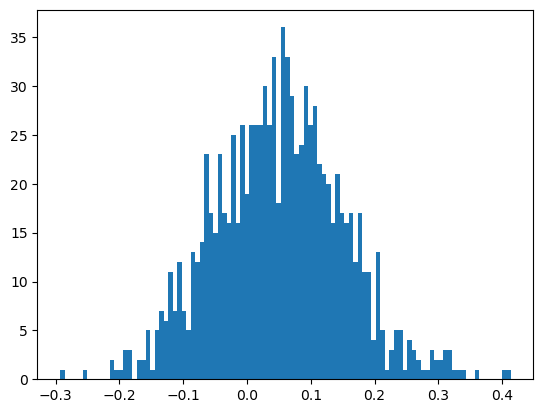

In [4]:
plt.hist(array_problem_1, bins = 100)
plt.show()

### 1C.

In [5]:
def calculate_aicc(log_likelihood, n, k):
    aic = 2 * k - 2 * log_likelihood
    aicc = aic + (2 * k * (k + 1)) / (n - k - 1)
    return aicc

# fit normal distribution
mu_norm, sigma_norm = norm.fit(array_problem_1)  
log_likelihood_norm = np.sum(norm.logpdf(array_problem_1, loc=mu_norm, scale=sigma_norm))  
aicc_norm = calculate_aicc(log_likelihood_norm, len(array_problem_1), 2)  

# fit t-distribution
df_t, loc_t, scale_t = t.fit(array_problem_1) 
log_likelihood_t = np.sum(t.logpdf(array_problem_1, df_t, loc=loc_t, scale=scale_t))  
aicc_t = calculate_aicc(log_likelihood_t, len(array_problem_1), 3)  

print(f"normal distribution: μ = {mu_norm:.4f}, σ = {sigma_norm:.4f}")
print(f"AICc of normal distribution: {aicc_norm:.4f}")

print(f"t distribution: ν = {df_t:.4f}, μ = {loc_t:.4f}, σ = {scale_t:.4f}")
print(f"AICc of t distribution: {aicc_t:.4f}")


normal distribution: μ = 0.0502, σ = 0.1016
AICc of normal distribution: -1731.5747
t distribution: ν = 28.7102, μ = 0.0499, σ = 0.0980
AICc of t distribution: -1731.3943


# Problem 2

In [6]:
df_problem_2 = pd.read_csv('problem2.csv')
df_problem_2.head(3)

,x1,x2,x3,x4,x5
0,0.378172,0.508313,NaN,0.610538,NaN
1,0.858478,0.758142,NaN,NaN,NaN
2,-0.218954,-0.015334,-0.26188,NaN,-0.230148


### 2A.

In [7]:
pairwise_cov_matrix = df_problem_2.cov() # df.cov() will calculate pairwise covariance automatically

# calculate mannually
# columns = df_problem_2.columns
# pairwise_cov_matrix = pd.DataFrame(index=columns, columns=columns, dtype = float)

# for col1 in columns:
#     for col2 in columns:
#         if col1 == col2:
#             valid_rows = df_problem_2[col1].dropna()
#             pairwise_cov_matrix.loc[col1, col2] = valid_rows.var()
#             continue
#         valid_rows = df_problem_2[[col1, col2]].dropna()  # find matching rows for each pair 
#         if not valid_rows.empty:  # exsiting matching rows
#             pairwise_cov_matrix.loc[col1, col2] = float(valid_rows[col1].cov(valid_rows[col2])) # calculate pairwise covariance


# pairwise_cov_matrix = pairwise_cov_matrix.astype(float)

print("Pairwise Covariance Matrix:")
print(pairwise_cov_matrix)

Pairwise Covariance Matrix:
          x1        x2        x3        x4        x5
x1  1.470484  1.454214  0.877269  1.903226  1.444361
x2  1.454214  1.252078  0.539548  1.621918  1.237877
x3  0.877269  0.539548  1.272425  1.171959  1.091912
x4  1.903226  1.621918  1.171959  1.814469  1.589729
x5  1.444361  1.237877  1.091912  1.589729  1.396186


### 2B. 

In [8]:
pairwise_cov_matrix = pairwise_cov_matrix.to_numpy()
eigenvalues = np.linalg.eigvals(pairwise_cov_matrix)  
if eigenvalues.min() >= 0:
    print('the Pairwise Covariance Matrix is positive semi-definite')
else:
    print('the Pairwise Covariance Matrix is not positive semi-definite')


the Pairwise Covariance Matrix is not positive semi-definite


### 2C.

In [9]:
import numpy as np

def _getAplus(A):
    """ Compute the nearest positive semi-definite matrix by replacing negative eigenvalues with zero. """
    eigvals, eigvecs = np.linalg.eigh(A)
    eigvals = np.maximum(eigvals, 0)  # Replace negative eigenvalues with zero
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

def _getPS(A, W):
    """ Compute the weighted projection onto the set of positive semi-definite matrices. """
    W_sqrt = np.sqrt(W)
    inv_W_sqrt = np.linalg.inv(W_sqrt)
    return inv_W_sqrt @ _getAplus(W_sqrt @ A @ W_sqrt) @ inv_W_sqrt

def _getPu(A, W):
    """ Projection onto the set of matrices with unit diagonal (correlation matrix constraint). """
    A_proj = A.copy()
    np.fill_diagonal(A_proj, 1.0)  # Set diagonal elements to 1
    return A_proj

def wgtNorm(A, W):
    """ Compute the weighted Frobenius norm. """
    W_sqrt = np.sqrt(W)
    return np.sum((W_sqrt @ A @ W_sqrt) ** 2)

def higham_nearestPSD(pc, W=None, epsilon=1e-9, max_iter=100, tol=1e-9):
    """
    Compute the nearest positive semi-definite matrix using Higham's iterative method.
    """
    n = pc.shape[0]
    if W is None:
        W = np.diag(np.ones(n))  # Default weight matrix as identity

    deltaS = np.zeros_like(pc)
    Yk = pc.copy()

    # Convert covariance to correlation matrix if necessary
    if not np.allclose(np.diag(Yk), np.ones(n)):
        invSD = np.diag(1.0 / np.sqrt(np.diag(Yk)))
        Yk = invSD @ Yk @ invSD
    else:
        invSD = None

    Yo = Yk.copy()
    norml = np.finfo(float).max

    for i in range(max_iter):
        Rk = Yk - deltaS
        Xk = _getPS(Rk, W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W)

        norm = wgtNorm(Yk - Yo, W)
        min_eig_val = np.min(np.real(np.linalg.eigvals(Yk)))

        if norm - norml < tol and min_eig_val > -epsilon:
            print(f"Converged in {i+1} iterations.")
            break

        norml = norm

    else:
        print(f"Convergence failed after {max_iter} iterations")

    # Convert back to covariance matrix if needed
    if invSD is not None:
        invSD = np.diag(1.0 / np.diag(invSD))
        Yk = invSD @ Yk @ invSD

    return Yk


pairwise_cov_matrix_psd = higham_nearestPSD(pairwise_cov_matrix)
print("PSD calculated by Higham's method':\n", pd.DataFrame(pairwise_cov_matrix_psd, index = df_problem_2.columns, columns = df_problem_2.columns))


Converged in 56 iterations.
PSD calculated by Higham's method':
           x1        x2        x3        x4        x5
x1  1.470484  1.332361  0.884378  1.627602  1.399556
x2  1.332361  1.252078  0.619028  1.450604  1.214450
x3  0.884378  0.619028  1.272425  1.076846  1.059658
x4  1.627602  1.450604  1.076846  1.814469  1.577928
x5  1.399556  1.214450  1.059658  1.577928  1.396186


In [10]:
def near_psd_rebonato(A: np.ndarray, epsilon=0.0)-> np.ndarray:
    """
    Find the nearest positive semi-definite matrix using the Rebonato & Jackel method.
    """
    n = A.shape[0]
    out = A.copy()

    # Check if the matrix is already a correlation matrix (diagonal elements = 1)
    if not np.allclose(np.diag(out), np.ones(n)):
        invSD = np.diag(1.0 / np.sqrt(np.diag(out)))
        out = invSD @ out @ invSD

    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(out)
    eigvals = np.maximum(eigvals, epsilon)  # Ensure non-negative eigenvalues

    T = 1.0 / (eigvecs ** 2 @ eigvals)
    T = np.diag(np.sqrt(T))
    L = np.diag(np.sqrt(eigvals))
    B = T @ eigvecs @ L
    out = B @ B.T

    # Restore covariance scaling
    if 'invSD' in locals():
        invSD = np.diag(1.0 / np.diag(invSD))
        out = invSD @ out @ invSD

    return out
A_psd_rebonato = near_psd_rebonato(pairwise_cov_matrix)
print("PSD calculated by Rebonato & Jackel's method:\n", pd.DataFrame(A_psd_rebonato, index = df_problem_2.columns, columns = df_problem_2.columns))


PSD calculated by Rebonato & Jackel's method:
           x1        x2        x3        x4        x5
x1  1.470484  1.327009  0.842583  1.624464  1.364833
x2  1.327009  1.252078  0.555421  1.433109  1.165906
x3  0.842583  0.555421  1.272425  1.052789  1.060424
x4  1.624464  1.433109  1.052789  1.814469  1.544993
x5  1.364833  1.165906  1.060424  1.544993  1.396186


### 2D. 

In [11]:
df_problem_2_overlapping = df_problem_2.dropna()
overlapping_cov_matrix = df_problem_2_overlapping.cov()
print("the covariance matrix using only overlapping data:\n")
print(overlapping_cov_matrix)

the covariance matrix using only overlapping data:

          x1        x2        x3        x4        x5
x1  0.418604  0.394054  0.424457  0.416382  0.434287
x2  0.394054  0.396786  0.409343  0.398401  0.422631
x3  0.424457  0.409343  0.441360  0.428441  0.448957
x4  0.416382  0.398401  0.428441  0.437274  0.440167
x5  0.434287  0.422631  0.448957  0.440167  0.466272


# Problem3

### 3A.

In [12]:
df_problem_3 = pd.read_csv('problem3.csv')
mean_est = df_problem_3.mean().values
cov_est = df_problem_3.cov().values
mean_est, cov_est

(array([0.04600157, 0.09991502]),
 array([[0.0101622 , 0.00492354],
        [0.00492354, 0.02028441]]))

### 3C.

Conditional mean of X2 | X1=0.6: 0.3682991696531456
Conditional variance of X2 | X1=0.6: 0.017851687950657936


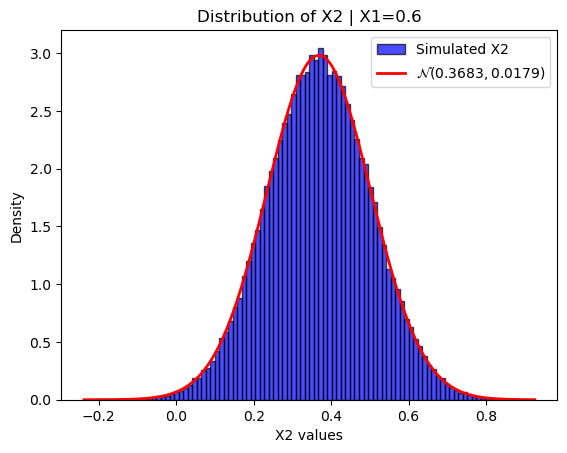

In [13]:
L = np.linalg.cholesky(cov_est)

X1 = 0.6
L11 = L[0, 0]
L21 = L[1, 0]
L22 = L[1, 1]


Z1 = (X1 - mean_est[0]) / L11

num_samples = 100000 
Z2 = np.random.normal(0, 1, num_samples)

X2 = L21 * Z1 + L22 * Z2 + mean_est[1]

print(f"Conditional mean of X2 | X1=0.6: {np.mean(X2)}")
print(f"Conditional variance of X2 | X1=0.6: {np.var(X2)}")


mu_cond = 0.3683
sigma_cond = np.sqrt(0.0179)
x = np.linspace(min(X2), max(X2), 500)
pdf = norm.pdf(x, mu_cond, sigma_cond)

plt.hist(X2, bins=100, density=True, alpha=0.7, color='blue', edgecolor='k', label="Simulated X2")
plt.plot(x, pdf, color='red', lw=2, label=r"$\mathcal{N}(0.3683, 0.0179)$")

plt.title("Distribution of X2 | X1=0.6")
plt.xlabel("X2 values")
plt.ylabel("Density")
plt.legend()

# Problem 4

### 4A.

In [14]:
df_problem_4 = pd.read_csv('problem4.csv')
series_y = pd.Series(df_problem_4['y'])

Text(0.5, 1.0, 'PACF of MA(3) Residuals')

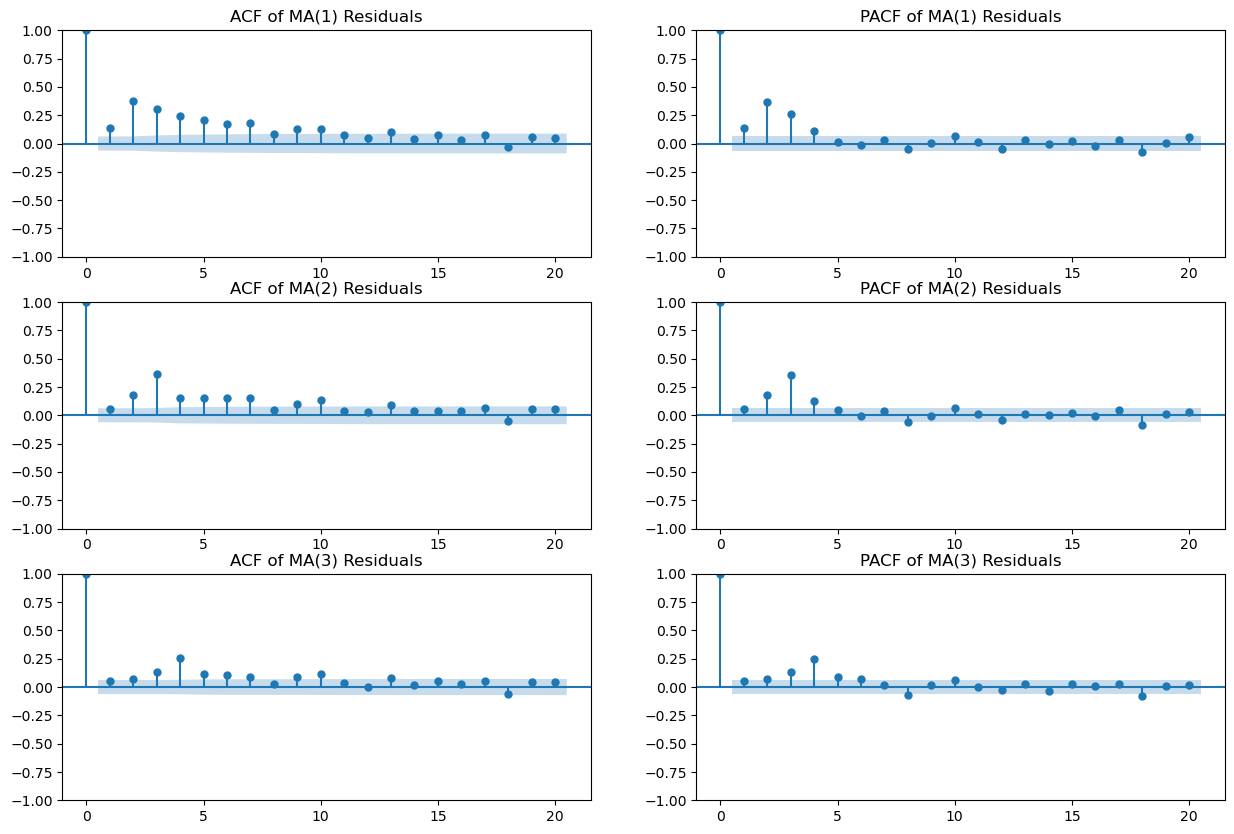

In [15]:
# fit MA(1) MA(2) MA(3)
from statsmodels.tsa.arima.model import ARIMA
# Specify ARIMA model with order (p,d,q) where p=0, d=0 for MA(q)
ma_1_mdl = ARIMA(series_y, order=(0, 0, 1)).fit()
ma_1_resid = ma_1_mdl.resid
ma_2_mdl = ARIMA(series_y, order=(0, 0, 2)).fit()
ma_2_resid = ma_2_mdl.resid
ma_3_mdl = ARIMA(series_y, order=(0, 0, 3)).fit()
ma_3_resid = ma_3_mdl.resid

# plot ACF and PACF of MA model residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2, figsize = (15, 10))
plot_acf(ma_1_resid, ax=axes[0, 0], lags=20)
axes[0, 0].set_title("ACF of MA(1) Residuals")
plot_pacf(ma_1_resid, ax=axes[0, 1], lags=20)
axes[0, 1].set_title("PACF of MA(1) Residuals")

plot_acf(ma_2_resid, ax=axes[1, 0], lags=20)
axes[1, 0].set_title("ACF of MA(2) Residuals")
plot_pacf(ma_2_resid, ax=axes[1, 1], lags=20)
axes[1, 1].set_title("PACF of MA(2) Residuals")

plot_acf(ma_3_resid, ax=axes[2, 0], lags=20)
axes[2, 0].set_title("ACF of MA(3) Residuals")
plot_pacf(ma_3_resid, ax=axes[2, 1], lags=20)
axes[2, 1].set_title("PACF of MA(3) Residuals")

### 4B.

Text(0.5, 1.0, 'PACF of AR(3) Residuals')

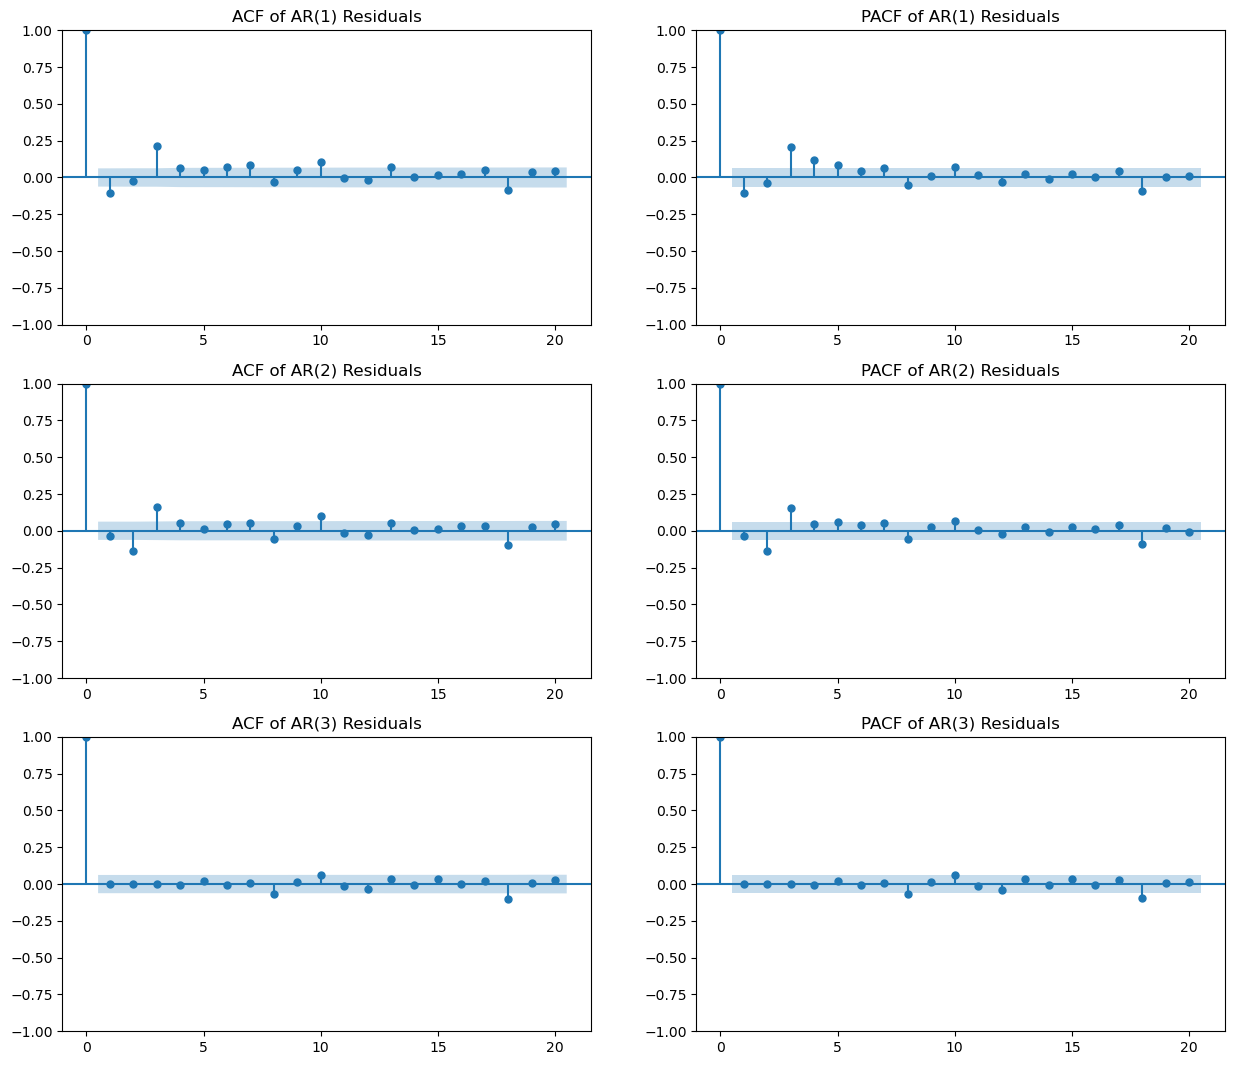

In [16]:
# fit AR(1) AR(2) AR(3)
# Specify ARIMA model with order (p,d,q) where q=0, d=0 for AR(p)
ar_1_mdl = ARIMA(series_y, order=(1, 0, 0)).fit()
ar_1_resid = ar_1_mdl.resid
ar_2_mdl = ARIMA(series_y, order=(2, 0, 0)).fit()
ar_2_resid = ar_2_mdl.resid
ar_3_mdl = ARIMA(series_y, order=(3, 0, 0)).fit()
ar_3_resid = ar_3_mdl.resid

# plot ACF and PACF of AR model residuals
fig, axes = plt.subplots(3, 2, figsize = (15, 13))
plot_acf(ar_1_resid, ax=axes[0, 0], lags=20)
axes[0, 0].set_title("ACF of AR(1) Residuals")
plot_pacf(ar_1_resid, ax=axes[0, 1], lags=20)
axes[0, 1].set_title("PACF of AR(1) Residuals")

plot_acf(ar_2_resid, ax=axes[1, 0], lags=20)
axes[1, 0].set_title("ACF of AR(2) Residuals")
plot_pacf(ar_2_resid, ax=axes[1, 1], lags=20)
axes[1, 1].set_title("PACF of AR(2) Residuals")

plot_acf(ar_3_resid, ax=axes[2, 0], lags=20)
axes[2, 0].set_title("ACF of AR(3) Residuals")
plot_pacf(ar_3_resid, ax=axes[2, 1], lags=20)
axes[2, 1].set_title("PACF of AR(3) Residuals")

### 4C.

Text(0.5, 1.0, 'PACF')

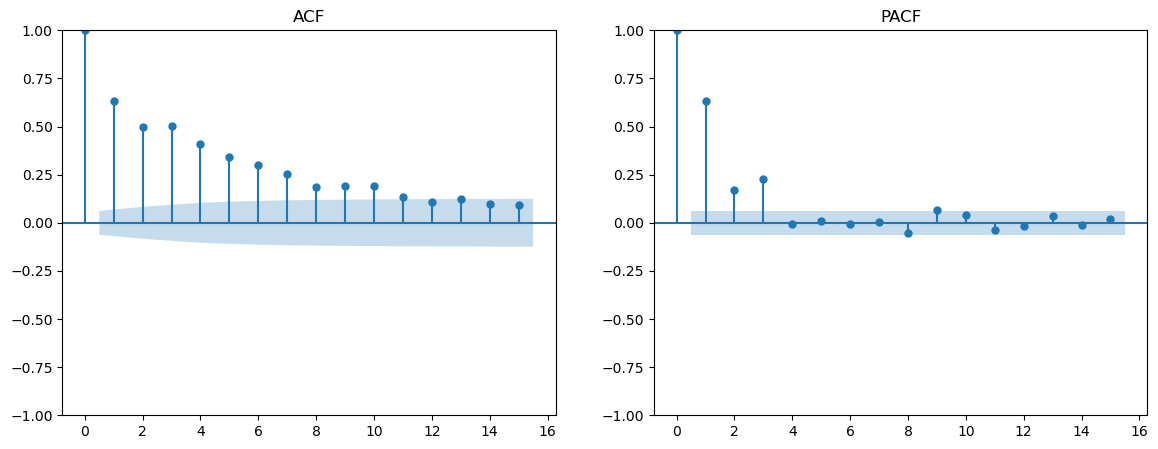

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(series_y, ax=axes[0], lags=15)  
axes[0].set_title("ACF")
plot_pacf(series_y, ax=axes[1], lags=15, method="ywm") 
axes[1].set_title("PACF")


In [18]:
samallest_aic = np.inf
best_order = 0
for p in range(1, 11):
    ar_mdl = ARIMA(series_y, order=(p, 0, 0)).fit()
    aic = ar_mdl.aic
    if aic < samallest_aic:
        best_order = p
        samallest_aic = aic
print(f'best order is {best_order}')
    

best order is 3


# Problem 5

In [19]:
df_problem_5 = pd.read_csv('DailyReturn.csv')
df_problem_5.head(3)

,Date,SPY,AAPL,NVDA,MSFT,AMZN,META,GOOGL,AVGO,TSLA,...,SBUX,MMC,MDT,CB,LMT,KKR,MU,PLD,LRCX,EQIX
0,2023-01-04,0.007720,0.010314,0.030318,-0.043743,-0.007924,0.021084,-0.011670,0.012214,0.051249,...,0.036001,0.019460,0.034628,0.016442,-0.002157,0.030420,0.076037,0.037892,0.019696,0.026626
1,2023-01-05,-0.011413,-0.010605,-0.032816,-0.029638,-0.023726,-0.003376,-0.021344,-0.009318,-0.029039,...,-0.000287,-0.018143,-0.011609,-0.003743,0.001196,-0.014553,0.009410,-0.035140,-0.012782,-0.028714
2,2023-01-06,0.022932,0.036794,0.041640,0.011785,0.035611,0.024263,0.013225,0.060196,0.024651,...,0.021641,0.029012,0.010371,0.023707,-0.008028,0.016456,0.037653,0.033673,0.067640,0.020163


### 5A.

In [20]:
def populate_weights(n: int, lambda_factor: float):
    """calculate exponential weights

    Args:
        n (int): length of data
        lambda_factor (float): decay factor λ between 0 an 1

    Returns:
        _type_: weight array, cumulative weight array
    """
    w = np.zeros(n)  
    cumulative_w = np.zeros(n)  
    total_w = 0.0  

    for i in range(n):
        w[i] = (1 - lambda_factor) * lambda_factor ** (i + 1)
        total_w += w[i]
        cumulative_w[i] = total_w

    w /= total_w
    cumulative_w /= total_w

    return w, cumulative_w


def exponentially_weighted_covariance_matrix(df: pd.DataFrame, lambda_factor: float):
    """calculate exponentially weighted covariance matrix

    Args:
        df (pd.DataFrame): 
        lambda_factor (float): decay factor λ between 0 an 1

    Returns:
        _type_: exponentially weighted covariance matrix
    """
    n = len(df)  
    weights, _ = populate_weights(n, lambda_factor)  
    weights = weights[::-1]  
    df = df.loc[:, df.columns != "Date"]
    means = (df.T * weights).sum(axis=1)  
    
    mean_centered = df - means  

    variables = df.columns
    cov_matrix = pd.DataFrame(index = variables, columns = variables, dtype = float)

    for i in variables:
        for j in variables:
            cov_matrix.loc[i, j] = np.sum(weights * mean_centered[i] * mean_centered[j])

    return cov_matrix





In [21]:
from sklearn.decomposition import PCA

def pca_analysis_with_varying_lambda(df: pd.DataFrame, lambda_factor: float):

    cov_matrix = exponentially_weighted_covariance_matrix(df, lambda_factor)

    pca = PCA()
    pca.fit(cov_matrix)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    return cumulative_variance



In [22]:
cumulative_variances = {}

lambda_values = [.1, .2, .3, .4, .5, .6, .7, .8]
for lambda_factor in lambda_values:
    cumulative_variance = pca_analysis_with_varying_lambda(df_problem_5, lambda_factor)
    cumulative_variances[lambda_factor] = cumulative_variance


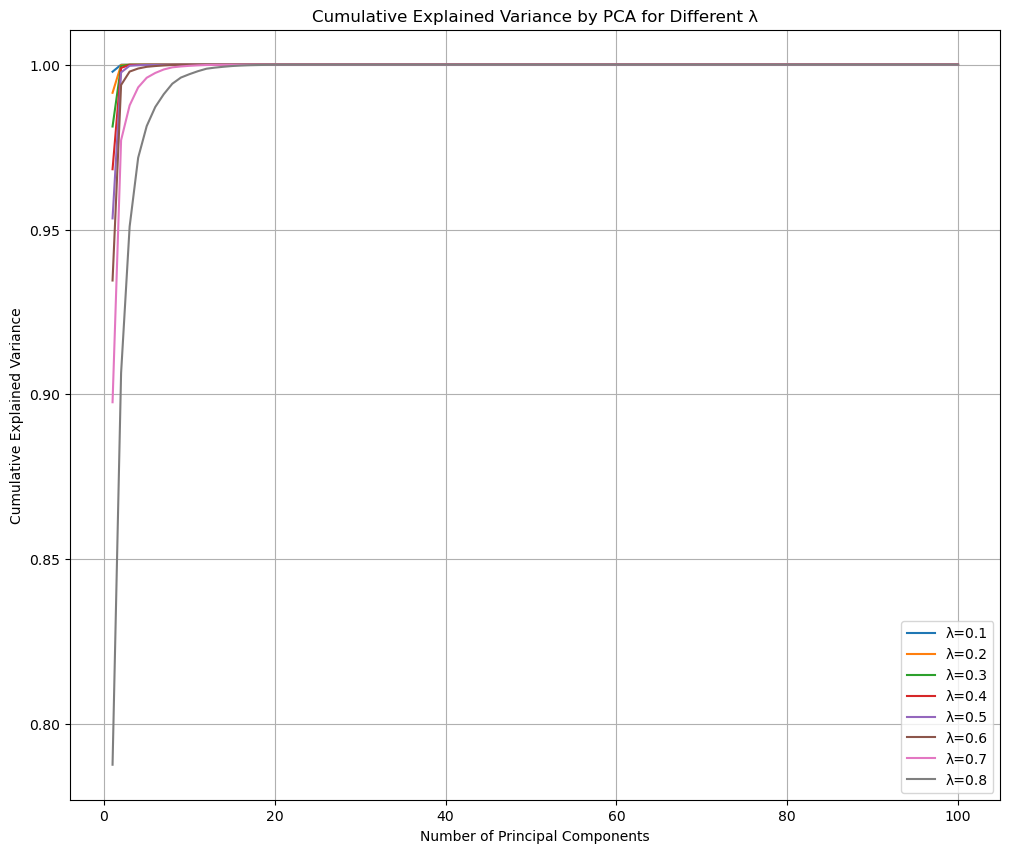

In [23]:
plt.figure(figsize=(12, 10))
for lambda_factor, cumulative_variance in cumulative_variances.items():
    plt.plot(
        range(1, len(cumulative_variance) + 1),
        cumulative_variance,
        label=f"λ={lambda_factor}",
    )
plt.title("Cumulative Explained Variance by PCA for Different λ")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.show()

# Problem 6

In [24]:
df_problem_6 = pd.read_csv('problem6.csv')
df_problem_6.head(3)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x491,x492,x493,x494,x495,x496,x497,x498,x499,x500
0,0.005315,0.000215,-0.000777,0.000418,-0.000687,0.000166,0.000935,-0.000445,0.000826,0.000146,...,0.001210,-0.000365,0.000155,-0.000881,-0.000284,-0.000149,0.000021,0.000237,0.001169,-0.000095
1,0.000215,0.001781,0.000094,-0.000109,-0.000438,0.000523,-0.000803,0.000242,0.000596,0.000129,...,0.000212,0.000256,-0.000106,-0.000080,0.000053,-0.000190,0.000009,0.000370,0.000707,0.000139
2,-0.000777,0.000094,0.004925,0.000320,-0.000592,0.000418,-0.000195,0.000543,0.001143,-0.000326,...,-0.000634,-0.000883,-0.000068,-0.000492,0.000222,-0.000761,-0.000269,-0.000335,0.000360,-0.000124


### 6A.

In [25]:
cov_matrix = df_problem_6.values
num_variables = cov_matrix.shape[0]  

n_simulations = 10000 # number of simulations
mean_vector = np.zeros(num_variables) # Mean vector (assumed to be zero)

cov_martix_psd = near_psd_rebonato(cov_matrix, epsilon = 1e-8)
start_time_cholesky = time.time() 
L = np.linalg.cholesky(cov_martix_psd) # Cholesky decomposition
Z = np.random.randn(num_variables, n_simulations) # standard normal samples
X_cholesky = (L @ Z).T # simulate using Cholesky root

end_time_cholesky = time.time()
time_cholesky = end_time_cholesky - start_time_cholesky

cov_cholesky = np.cov(X_cholesky, rowvar=False) # Compute covariance of the simulated dataset

### B.

In [26]:
start_time_pca = time.time()

# Perform PCA
pca = PCA(n_components=0.75)  # Retain 75% variance
pca.fit(cov_matrix)

# Transform standard normal variables
Z_pca = np.random.randn(len(pca.components_), n_simulations)
X_pca = (pca.components_.T @ np.diag(np.sqrt(pca.explained_variance_)) @ Z_pca).T

end_time_pca = time.time()
time_pca = end_time_pca - start_time_pca

# Compute covariance of the PCA simulated dataset
cov_pca = np.cov(X_pca, rowvar=False)


### 6C.

In [27]:
frobenius_cholesky = np.linalg.norm(cov_cholesky - cov_matrix, ord='fro')
frobenius_pca = np.linalg.norm(cov_pca - cov_matrix, ord='fro')
print(f'frobenius_cholesky: {frobenius_cholesky}')
print(f'frobenius_pca: {frobenius_pca}')

frobenius_cholesky: 0.020705170342929183
frobenius_pca: 0.26028846397251626


### 6D.

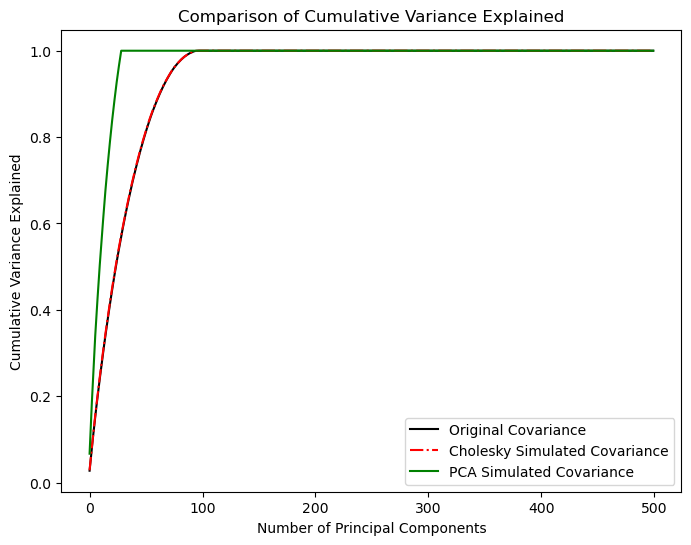

In [28]:
original_eigenvalues = np.linalg.eigvalsh(cov_matrix)[::-1]  # Descending order
cumulative_original = np.cumsum(original_eigenvalues) / np.sum(original_eigenvalues)

cholesky_eigenvalues = np.linalg.eigvalsh(cov_cholesky)[::-1]
cumulative_cholesky = np.cumsum(cholesky_eigenvalues) / np.sum(cholesky_eigenvalues)

pca_eigenvalues = np.linalg.eigvalsh(cov_pca)[::-1]
cumulative_pca = np.cumsum(pca_eigenvalues) / np.sum(pca_eigenvalues)

# Plot cumulative variance explained
plt.figure(figsize=(8, 6))
plt.plot(cumulative_original, label="Original Covariance", color = 'black')
plt.plot(cumulative_cholesky, label="Cholesky Simulated Covariance", linestyle = '-.', color = 'red')
plt.plot(cumulative_pca, label="PCA Simulated Covariance", color = 'green')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.legend()
plt.title("Comparison of Cumulative Variance Explained")
plt.show()


### 6E. 

In [29]:
print(f'time cost by Cholesky Root method: {time_cholesky:.4f} s')
print(f'time cost by PCA method: {time_pca:.4f} s')

time cost by Cholesky Root method: 0.4580 s
time cost by PCA method: 0.1135 s
